In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

### Filter profiles

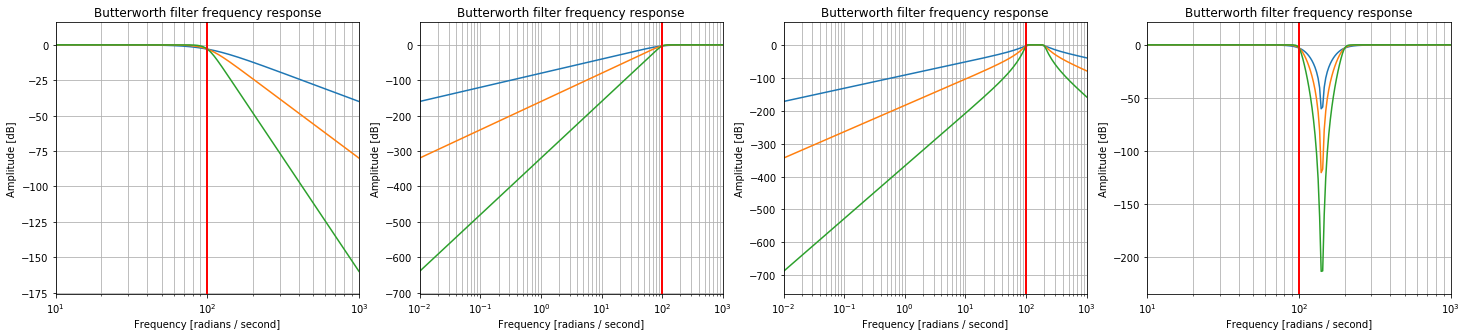

In [3]:
threshFreq = 100
fig, ax = plt.subplots(1,4,figsize=(25,5))
for i, filterType in enumerate(['lowpass','highpass','bandpass','bandstop']):
    for order in [2,4,8]:
        try:
            b, a = signal.butter(order, threshFreq, filterType, analog=True)
        except:
            b, a = signal.butter(order, [threshFreq,2.0*threshFreq], filterType, analog=True)
        w, h = signal.freqs(b, a)
        ax[i].semilogx(w, 20 * np.log10(abs(h)))
        ax[i].set_title('Butterworth filter frequency response')
        ax[i].set_xlabel('Frequency [radians / second]')
        ax[i].set_ylabel('Amplitude [dB]')
        ax[i].margins(0, 0.1)
        ax[i].grid(which='both', axis='both')
        ax[i].axvline(threshFreq, color='red') # cutoff frequency


### Filter results

(501, 1)


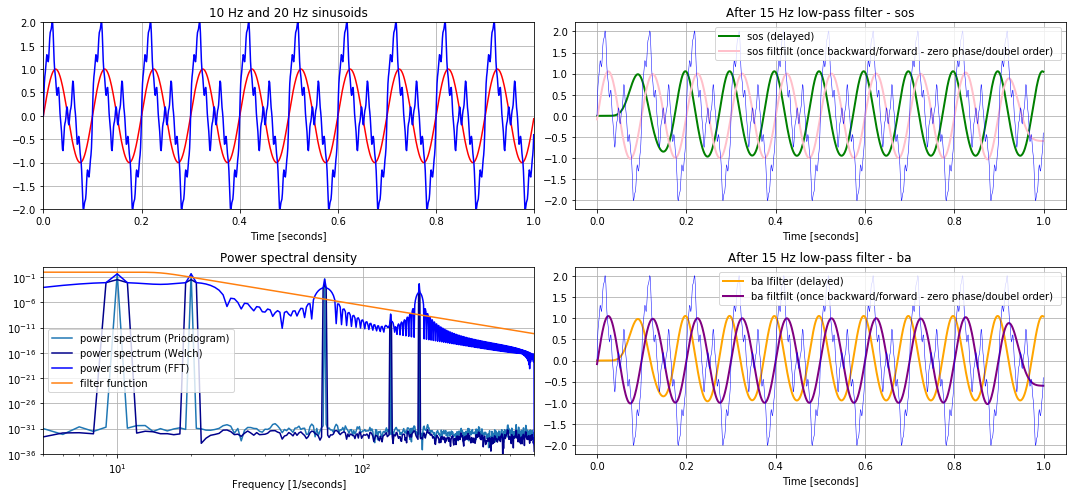

In [6]:
t = np.linspace(0, 1, 1000, False)  # 1 second
sig0 = np.sin(2*np.pi*10*t)
sig1 = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t) + 0.3*np.sin(2*np.pi*70*t)+ 0.1*np.sin(2*np.pi*170*t)+ 0.0001*np.sin(2*np.pi*130*t)

threshFreq = 15

fig, ax = plt.subplots(2, 2, figsize=(15,7))
ax[0,0].plot(t, sig0, color='red')
ax[0,0].plot(t, sig1, color='blue')
ax[0,0].set_title('10 Hz and 20 Hz sinusoids')
ax[0,0].set_xlabel('Time [seconds]')
ax[0,0].grid(True)
ax[0,0].axis([0, 1, -2, 2])
    
f, Pxx_den = signal.periodogram(sig1, fs=1000)
ax[1,0].loglog(f, Pxx_den                    ,label='power spectrum (Priodogram)')

f, Pxx_den = signal.welch(sig1, fs=1000, nperseg=1000)
ax[1,0].loglog(f, Pxx_den/10,color='darkblue',label='power spectrum (Welch)')

f, tm, Sxx = signal.spectrogram(sig1, fs=1000, nperseg=1000)
print(Sxx.shape)
ax[1,0].loglog(f, Sxx[:,0]  ,color='blue',    label='power spectrum (FFT)')


b, a = signal.butter(order, threshFreq, 'lowpass', analog=True)
w, h = signal.freqs(b, a, worN=np.logspace(0, 3, 1000))
ax[1,0].loglog(w, abs(h),label='filter function')

ax[1,0].axis([5, 500,10**(-36),10])
ax[1,0].set_title('Power spectral density')
ax[1,0].set_xlabel('Frequency [1/seconds]')
ax[1,0].grid(True)
ax[1,0].legend()

sos = signal.butter(10, threshFreq, 'lowpass', fs=1000, output='sos')
filtered11 = signal.sosfilt(sos, sig1)
filtered12 = signal.sosfiltfilt(sos, sig1)
ax[0,1].plot(t, filtered11,color='green',linewidth=2,label='sos (delayed)')
ax[0,1].plot(t, filtered12,color='pink',linewidth=2,label='sos filtfilt (once backward/forward - zero phase/doubel order) ')

b,a = signal.butter(10, threshFreq, 'lowpass',fs=1000, output='ba')
zi = signal.lfilter_zi(b, a)
filtered21 = signal.lfilter(b, a, sig1, zi=zi*sig1[0])[0]
filtered22 = signal.filtfilt(b, a, sig1)
ax[1,1].plot(t, filtered21,color='orange',linewidth=2,label='ba lfilter (delayed)')
ax[1,1].plot(t, filtered22,color='purple',linewidth=2,label='ba filtfilt (once backward/forward - zero phase/doubel order) ')

ax[0,1].set_title('After '+str(threshFreq)+' Hz low-pass filter - sos')
ax[0,1].set_xlabel('Time [seconds]')
ax[0,1].grid(True)
ax[0,1].legend()
ax[0,1].plot(t, sig1, color='blue',linewidth=0.5)

ax[1,1].set_title('After '+str(threshFreq)+' Hz low-pass filter - ba')
ax[1,1].set_xlabel('Time [seconds]')
ax[1,1].grid(True)
ax[1,1].legend()
ax[1,1].plot(t, sig1, color='blue',linewidth=0.5)

plt.tight_layout()
plt.show()

(1025, 55)


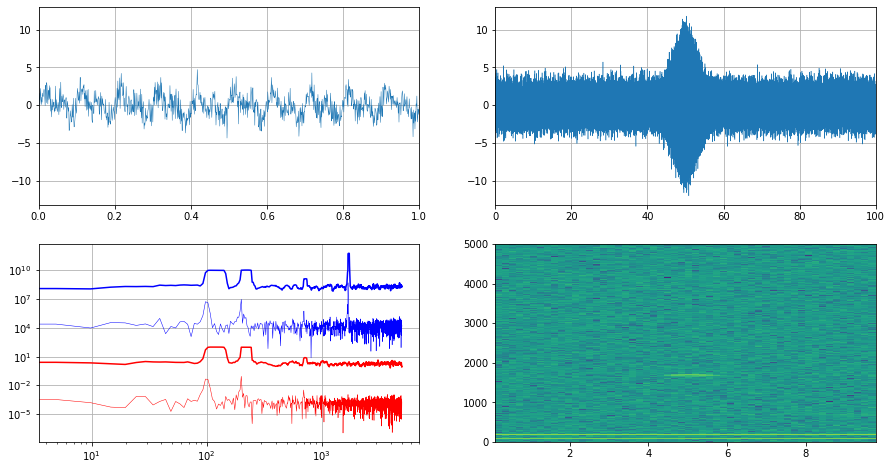

In [7]:
t = np.linspace(0, 100, 100000, False)  # 1 second

signale_noise = np.random.normal(0, 1.0, len(t))
signal_clean  = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t) + 0.3*np.sin(2*np.pi*70*t)+ 8*np.exp(-(t-50)**2/20)*np.sin(2*np.pi*170*t)+ 0.0001*np.sin(2*np.pi*130*t) 
sig2          = signal_clean + signale_noise

f, tm, Sxx = signal.spectrogram(sig2, fs=10000, nperseg=2048)
print(Sxx.shape)

fig, ax = plt.subplots(2, 2, figsize=(15,8))

ax[0,0].plot(t,sig2,linewidth=0.5)
ax[0,0].set_xlim(0,1)
ax[0,0].grid(True)

ax[0,1].plot(t,sig2,linewidth=0.5)
ax[0,1].set_xlim(0,100)
ax[0,1].grid(True)

ax[1,0].loglog(f,       Sxx[:,0] ,linewidth=0.5,color='red')
ax[1,0].loglog(f, 10**4*pd.Series(Sxx[:,0]).rolling(window=10, min_periods=1).mean(),color='red',linestyle='-')
ax[1,0].loglog(f, 10**8*Sxx[:,27],linewidth=0.5,color='blue')
ax[1,0].loglog(f, 10**12*pd.Series(Sxx[:,27]).rolling(window=10, min_periods=1).mean(),color='blue',linestyle='-')
ax[1,0].grid(True)
ax[1,1].pcolormesh(tm, f, np.log2(Sxx))
